In [1]:
import torch 
import torchvision
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
from matplotlib import pyplot as plt
from PIL import Image
import glob2
import numpy as np
import albumentations as A 
import copy
from albumentations.pytorch import ToTensor
import cv2
from tqdm import tqdm
import os
import subprocess

## Prediction

In [2]:
unet_test = torch.load("/content/drive/MyDrive/Colab Notebooks/Unet/unet_mask_jit.pt",map_location='cpu')

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:589: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  " silence this warning)", UserWarning)


In [3]:
import pickle

file = open('image_list.pkl', 'rb')
image_list = pickle.load(file)
file.close()


In [4]:
def combine_mask_images(img1_mask,img2_mask):
  mask = img2_mask > 0.5
  comb_mask = img1_mask.copy()
  comb_mask[mask] = img2_mask[mask]
  return comb_mask

In [5]:
loader = transforms.Compose([ transforms.Resize(size=(512,512)),transforms.ToTensor()])
from PIL import Image

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = loader(image).float()
    image = image.unsqueeze(0)  
    return image  #assumes that you're using GPU

In [23]:
def calculate_mask(unet_test,image_path):
  unet_test.eval()
  with torch.no_grad():
    image_tensor = image_loader(image_path)
    eyes,lips = unet_test(image_tensor)
    eyes = torch.sigmoid(eyes)
    eyes[eyes>0.5]=1.0
    eyes[eyes<=0.5]=0.0
    eyes = eyes.view(512,512,1)
    lips = torch.sigmoid(lips)
    lips[lips>0.5]=1.0
    lips[lips<=0.5]=0.0
    lips = lips.view(512,512,1)

  final_mask = combine_mask_images(eyes.numpy(), lips.numpy())
  image = image_tensor.squeeze()
  image = ((image.permute(1,2,0).numpy())*255).astype(np.uint8)

  final_mask = np.uint8(255*final_mask)
  final_mask = cv2.applyColorMap(final_mask, cv2.COLORMAP_PINK )

  superimposed_img = cv2.addWeighted(image, 1., final_mask, 0.6, 0) 
  return image, final_mask, superimposed_img

def visualize_result(unet_test,image_list):
  figure, ax = plt.subplots(nrows=len(image_list), ncols=3, figsize=(18, 8))
  for i,image_path in enumerate (image_list):
    image, final_mask, superimposed_img = calculate_mask(unet_test,image_path)
    ax[i, 0].imshow(image) # (3,512,512) --> (512,512,3)
    ax[i, 1].imshow(final_mask.squeeze(), interpolation="nearest")  # (1,512,512) to (512,512)
    ax[i, 2].imshow(superimposed_img.squeeze(), interpolation="nearest") 
    ax[i, 0].set_title("Image")
    ax[i, 1].set_title("Masks")
    ax[i, 2].set_title("Image + Masks")
    ax[i, 0].set_axis_off()
    ax[i, 1].set_axis_off()
  plt.tight_layout()
  plt.show()

In [24]:
val_2_images = image_list[-212:-210]
val_2_images

['/content/CelebA-HQ-img/17433.jpg', '/content/CelebA-HQ-img/11415.jpg']

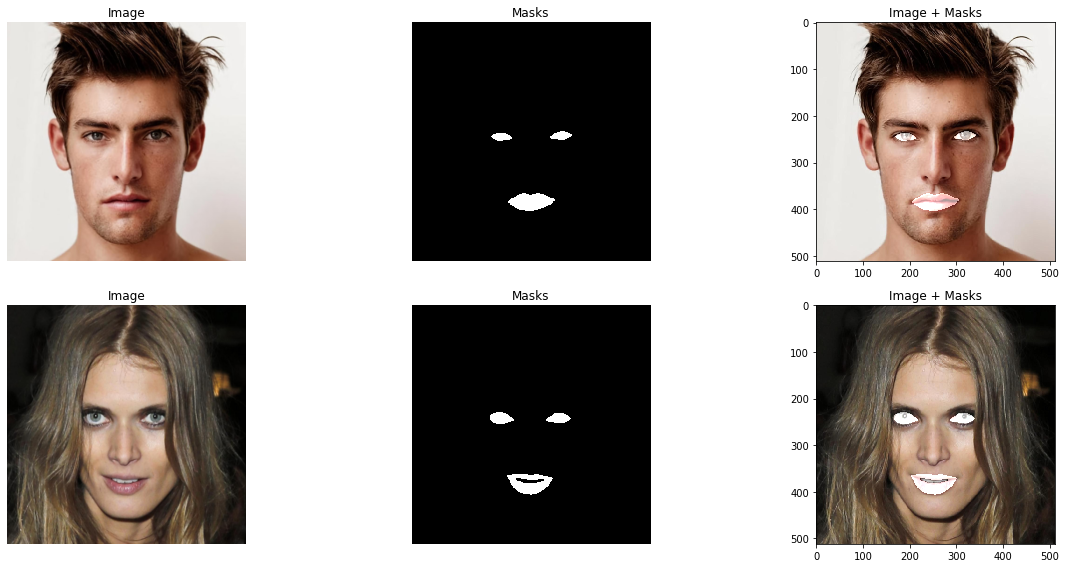

In [25]:
visualize_result(unet_test,val_2_images)